In [1]:
# Import necessary library files
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
from dotenv import load_dotenv
import glob
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Activation, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras import backend as K
import visualkeras
tf.__version__

'2.8.0'

In [2]:
# Load env vars
load_dotenv()

True

In [3]:
if os.getenv('CUDA_OPTIMIZE'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.compat.v1.disable_eager_execution()


In [4]:
DATA_PATH_PREFIX = os.getenv('DATA_PATH_PREFIX') if os.getenv('DATA_PATH_PREFIX') else 'dataset/'


In [5]:
# Set common params
im_height = 200
im_width = 200
num_channels = 3
num_p = 20
num_im = 100

In [6]:
def random_element(exclude, range_):
    return random.choice(list(set([x for x in range(0, range_)]) - set([exclude])))

def generate_pairs(vid):
    
#     y1, y2, y3, y4
#     s1, s2, s3, s4
#     y1, yr 1
#     y1, sr 0
#     y2, yr 1
#     y2, sr 0
#     y3, yr
#     y3, sr
#     y4, yr 1
#     y4, sr, 0

#     2,4
#     im[0][2] -> 0th person, 2nd image
#     im[1][1] -> 

#     75*20*100*2
    
    images = np.zeros((num_p, num_im, im_height, im_width,
                      num_channels), dtype='uint8')
    path = DATA_PATH_PREFIX+'jpg_Extracted_PIDS/'+str(vid)+'/'
    folders = ([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])
    folders.sort() # People
    folders = folders[1:1+num_p]
    for i,folder in enumerate(folders):
        temp_path = path+folder+'/'
        files = glob.glob(temp_path+'*', recursive=True) # Image
        files = random.choices(files, k=num_im)
        for j,filename in enumerate(files):
            with Image.open(filename) as im:
                im = im.resize((im_height, im_width))
                images[i,j] = np.array(im)
                
#     plt.imshow(images[1,0].astype("uint8"))
    X = np.zeros((num_p*num_im*2, 2, im_height, im_width, num_channels), dtype='uint8')  # (16 X 2 X 200 X 200 X 3)
    Y = np.zeros((num_p*num_im*2), dtype='uint8')
    v = 0
    for i in range(num_p):
        for j in range(num_im):
            p1 = np.concatenate(([images[i][j]],[images[i][random_element(j,num_im)]]))
            p2 = np.concatenate(([images[i][j]],[images[random_element(i,num_p)][random_element(j,num_im)]]))
            X[v] = p1
            Y[v] = 1.0
            v+=1
            X[v] = p2
            Y[v] = 0.0
            v+=1
    
    return X,Y


In [7]:
X, Y = generate_pairs('12-11-2019-4-1')
print(X.shape, Y.shape)

(4000, 2, 200, 200, 3) (4000,)


In [8]:
path = DATA_PATH_PREFIX+'jpg_Extracted_PIDS/'
folders = ([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])
# print(folders)
print("Number of videos:", len(folders))

Number of videos: 75


In [9]:
# Training with a generator
def data_generator(batch_size, eph):
    for _ in range(eph):
#         steps = 300000//batch_size
        # our steps will be 3000
        for f in folders:
            X_batch, Y_batch = generate_pairs(f) # 4000
            for i in  range(0, num_p*num_im*2, batch_size):
                yield [X_batch[i:i+batch_size, 0], X_batch[i:i+batch_size, 1]], Y_batch[i:i+batch_size]

In [10]:
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(im_height, im_width, num_channels),
    include_top=False,
)
# Freeze the base_model
base_model.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def l1_distance(inputs):
    input1, input2 = inputs
    output = K.abs(input1 - input2)
    return output

def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [12]:
def siamese_model():
    input1 = Input(shape=(im_height, im_width, num_channels,))
    input2 = Input(shape=(im_height, im_width, num_channels,))
    processed_input1 = tf.keras.applications.inception_v3.preprocess_input(input1)
    processed_input2 = tf.keras.applications.inception_v3.preprocess_input(input2)
    feature_vec1 = base_model(processed_input1)
    feature_vec2 = base_model(processed_input2)
    pool1 = GlobalAveragePooling2D()(feature_vec1) # 6x6x2048 -> 2048
    pool2 = GlobalAveragePooling2D()(feature_vec2)
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([pool1, pool2])
#     pool = GlobalAveragePooling2D()(distance)
    d1 = Dense(256)(distance)
    d2 = Dense(1)(d1)
    output = Activation('sigmoid')(d2)
    return Model(inputs=[input1, input2], outputs=output)

In [23]:
def plot_history(histories):
    # summarize history for accuracy
    plt.plot(histories['train'].history['binary_accuracy'])
    plt.plot(histories['tune'].history['binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'tune'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(histories['train'].history['loss'])
    plt.plot(histories['tune'].history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'tune'], loc='upper left')
    plt.show()


In [14]:
visualize = lambda model: display(visualkeras.layered_view(model, to_file='architecture.png', legend=True))

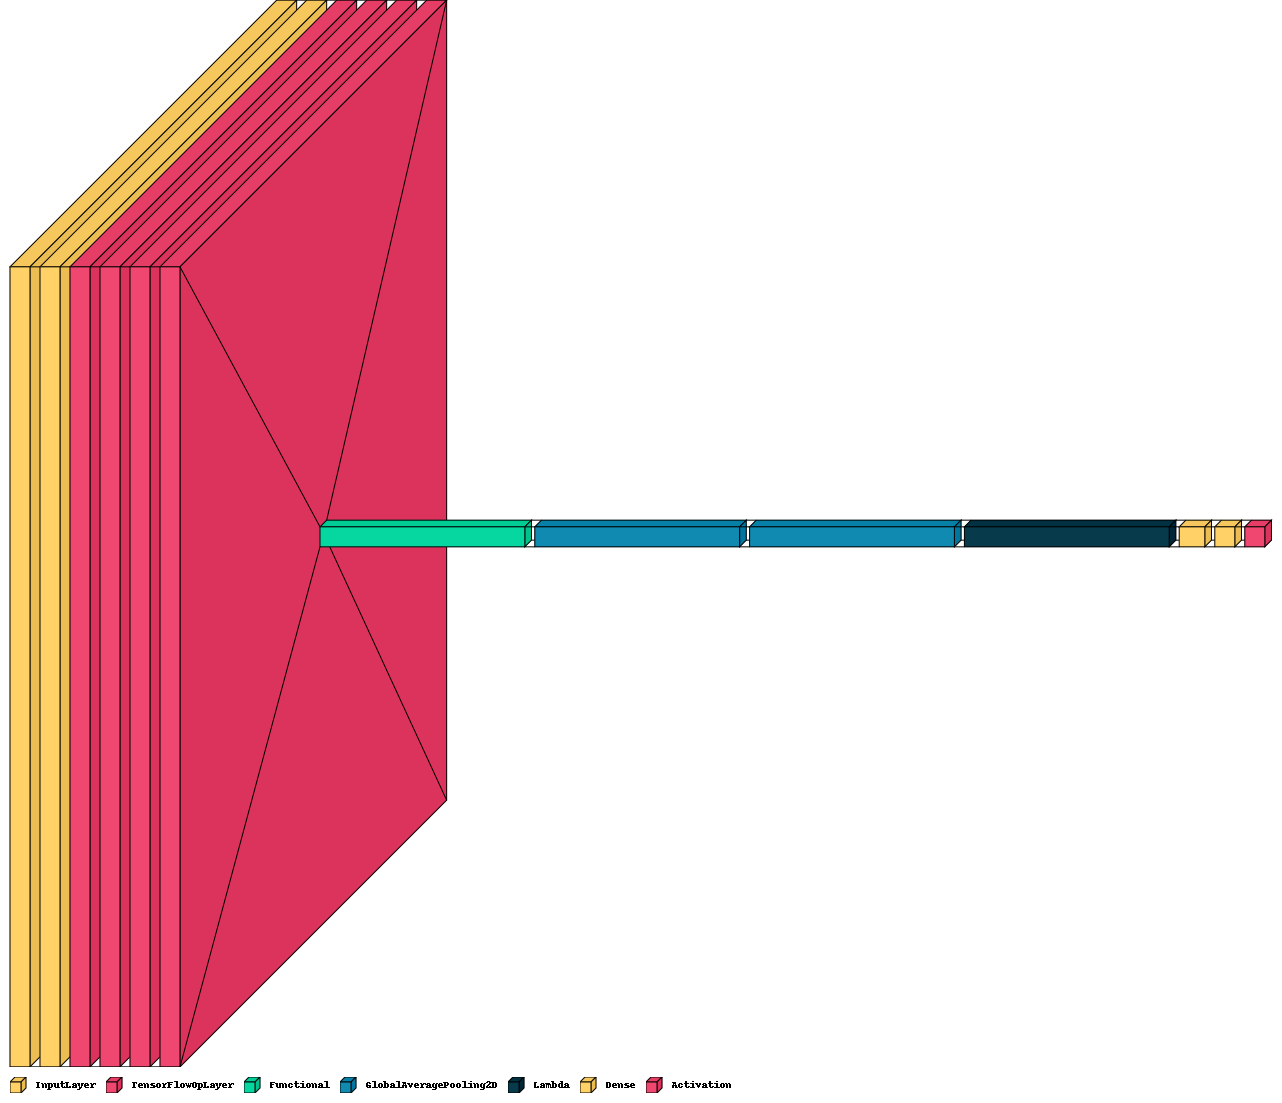

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf_op_layer_truediv (TensorFlo  [(None, 200, 200, 3  0          ['input_2[0][0]']                
 wOpLayer)                      )]                                                            

In [15]:
model = siamese_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
visualize(model)
model.summary()

In [16]:
history = {}

In [17]:
bs = int(os.getenv('BATCH_SIZE_TRAIN')) if os.getenv('BATCH_SIZE_TRAIN') else 100
eph = 5
history['train'] = model.fit(data_generator(bs, eph), epochs=eph, steps_per_epoch=3000)
# model.fit([X[:,0], X[:,1]], Y, batch_size=bs, epochs=eph)


Epoch 1/5
3000/3000 [==============================] - 91s 28ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.5575 - binary_accuracy: 0.7853
Epoch 2/5
3000/3000 [==============================] - 89s 30ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.4878 - binary_accuracy: 0.7790
Epoch 3/5
3000/3000 [==============================] - 84s 28ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.5231 - binary_accuracy: 0.7540
Epoch 4/5
3000/3000 [==============================] - 82s 27ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.5186 - binary_accuracy: 0.7650
Epoch 5/5
3000/3000 [==============================] - 84s 27ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.5047 - binary_accuracy: 0.7760


In [18]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    )
bs = int(os.getenv('BATCH_SIZE_TUNE')) if os.getenv('BATCH_SIZE_TUNE') else 10
eph = 5
history['tune'] = model.fit(data_generator(bs, eph), epochs=eph, steps_per_epoch=3000)
# model.fit([X[:,0], X[:,1]], Y, epochs=eph, batch_size=bs)


Epoch 1/5
3000/3000 [==============================] - 274s 88ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.2180 - binary_accuracy: 0.9227
Epoch 2/5
3000/3000 [==============================] - 257s 86ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.2517 - binary_accuracy: 0.9007
Epoch 3/5
3000/3000 [==============================] - 257s 86ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.2734 - binary_accuracy: 0.9007
Epoch 4/5
3000/3000 [==============================] - 253s 84ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.1829 - binary_accuracy: 0.9297
Epoch 5/5
3000/3000 [==============================] - 252s 83ms/step - batch: 1499.5000 - size: 1.0000 - loss: 0.2144 - binary_accuracy: 0.9210


In [19]:
model.save('siamese_1vid.h5')

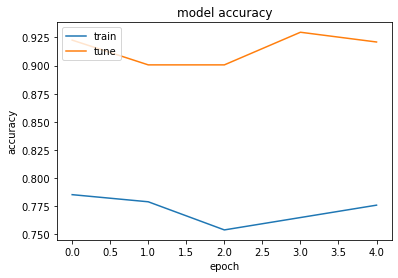

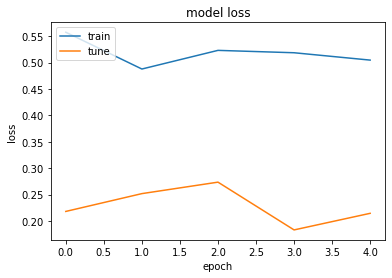

In [24]:
plot_history(history)

References:
    https://github.com/aup8497/Person-Re-identification-using-Siamese-networks/blob/master/Code/siamese_model.py

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from sys import platform
# If the platform is macOS
if platform == 'darwin':
    ### Aman's code to enable the GPU
    from tensorflow.python.compiler.mlcompute import mlcompute
    tf.compat.v1.disable_eager_execution()
    mlcompute.set_mlc_device(device_name='gpu')
    print("is_apple_mlc_enabled %s" % mlcompute.is_apple_mlc_enabled())
    print("is_tf_compiled_with_apple_mlc %s" % mlcompute.is_tf_compiled_with_apple_mlc())
print(f"eagerly? {tf.executing_eagerly()}")
print(tf.config.list_logical_devices())


eagerly? True
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
